In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e1/sample_submission.csv
/kaggle/input/playground-series-s5e1/train.csv
/kaggle/input/playground-series-s5e1/test.csv


In [2]:
# Load dataset
sales_data = pd.read_csv("/kaggle/input/playground-series-s5e1/train.csv")  # Adjust file name/path

test_data = pd.read_csv("/kaggle/input/playground-series-s5e1/test.csv")


# Get the size of the dataset
rows, columns = sales_data.shape

print(f"The dataset contains {rows} rows and {columns} columns.")

The dataset contains 230130 rows and 6 columns.


In [3]:
# Check structure
print(sales_data.head(50))

    id        date  country                 store             product  \
0    0  2010-01-01   Canada     Discount Stickers   Holographic Goose   
1    1  2010-01-01   Canada     Discount Stickers              Kaggle   
2    2  2010-01-01   Canada     Discount Stickers        Kaggle Tiers   
3    3  2010-01-01   Canada     Discount Stickers            Kerneler   
4    4  2010-01-01   Canada     Discount Stickers  Kerneler Dark Mode   
5    5  2010-01-01   Canada     Stickers for Less   Holographic Goose   
6    6  2010-01-01   Canada     Stickers for Less              Kaggle   
7    7  2010-01-01   Canada     Stickers for Less        Kaggle Tiers   
8    8  2010-01-01   Canada     Stickers for Less            Kerneler   
9    9  2010-01-01   Canada     Stickers for Less  Kerneler Dark Mode   
10  10  2010-01-01   Canada  Premium Sticker Mart   Holographic Goose   
11  11  2010-01-01   Canada  Premium Sticker Mart              Kaggle   
12  12  2010-01-01   Canada  Premium Sticker Mart  

In [4]:
print(sales_data.info())
print(sales_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB
None
                  id       num_sold
count  230130.000000  221259.000000
mean   115064.500000     752.527382
std     66432.953062     690.165445
min         0.000000       5.000000
25%     57532.250000     219.000000
50%    115064.500000     605.000000
75%    172596.750000    1114.000000
max    230129.000000    5939.000000


In [5]:
# Check for duplicate rows in the entire dataset
duplicates = sales_data.duplicated(subset=None)  # By default, checks all columns
duplicate_rows = sales_data[duplicates]

# Print the number of duplicate rows and the rows themselves
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")
print(duplicate_rows)


Number of duplicate rows: 0
Empty DataFrame
Columns: [id, date, country, store, product, num_sold]
Index: []


In [6]:
# Check for null values in each column
null_values = sales_data.isnull().sum()

# Display the columns with their respective null value counts
print(null_values)

id             0
date           0
country        0
store          0
product        0
num_sold    8871
dtype: int64


In [7]:
# checking the percentage of missing value
missing_percentage = sales_data['num_sold'].isnull().sum() / len(sales_data) * 100
print(f"Missing target values: {missing_percentage:.2f}%")

Missing target values: 3.85%


In [8]:
# Reset index if 'date' was set as the index
sales_data.reset_index(inplace=True)

In [9]:
# Replace any empty strings or other placeholders with NaN
sales_data['num_sold'] = sales_data['num_sold'].replace("", float("nan"))

# Recheck the missing values
print(sales_data['num_sold'].isnull().sum())


8871


### Group Consecutive Missing Days Together

trying to goup consecutive missing days.

In [10]:
# Identify gaps in 'num_sold' where values are missing
is_missing = sales_data['num_sold'].isnull()
gap_id = (is_missing != is_missing.shift()).cumsum()

# Filter for rows where 'num_sold' is missing
missing_gaps = sales_data[is_missing].assign(gap_id=gap_id).groupby('gap_id').agg(
    gap_length=('gap_id', 'size'),
    gap_start=('date', 'min'),
    gap_end=('date', 'max')
).reset_index()

# Display the missing gaps and their lengths
print(missing_gaps)


      gap_id  gap_length   gap_start     gap_end
0          1           1  2010-01-01  2010-01-01
1          3           1  2010-01-01  2010-01-01
2          5           1  2010-01-02  2010-01-02
3          7           1  2010-01-02  2010-01-02
4          9           1  2010-01-03  2010-01-03
...      ...         ...         ...         ...
8865   17731           1  2016-12-29  2016-12-29
8866   17733           1  2016-12-30  2016-12-30
8867   17735           1  2016-12-30  2016-12-30
8868   17737           1  2016-12-31  2016-12-31
8869   17739           1  2016-12-31  2016-12-31

[8870 rows x 4 columns]


### Checking for Date Gaps

AS there are no consecutive missing values in the dataset, trying to check for consecutive date missing gaps

In [11]:
# Ensure the 'date' column is in datetime format
sales_data['date'] = pd.to_datetime(sales_data['date'])

# Identify rows with missing values in 'num_sold'
is_missing = sales_data['num_sold'].isnull()

# Select only the rows with missing values
missing_data = sales_data[is_missing].copy()

# Calculate the previous date and date difference for missing rows
missing_data['prev_date'] = missing_data['date'].shift(1)
missing_data['date_diff'] = (missing_data['date'] - missing_data['prev_date']).dt.days

# Select the relevant columns for investigation
missing_date_diff = missing_data.loc[:, ['date', 'prev_date', 'date_diff']]

# Display the first few rows of the result
print(missing_date_diff.head(200))


           date  prev_date  date_diff
0    2010-01-01        NaT        NaN
45   2010-01-01 2010-01-01        0.0
90   2010-01-02 2010-01-01        1.0
135  2010-01-02 2010-01-02        0.0
180  2010-01-03 2010-01-02        1.0
...         ...        ...        ...
4325 2010-02-18 2010-02-18        0.0
4365 2010-02-18 2010-02-18        0.0
4370 2010-02-18 2010-02-18        0.0
4375 2010-02-18 2010-02-18        0.0
4410 2010-02-19 2010-02-18        1.0

[200 rows x 3 columns]



### Grouping the dataset by available columns

***There are no consecutive gaps in date or num_sold variables, so they are scattered in the dataset. But I am going to check this once again by grouping them***

In [12]:
# Step 1: Ensure 'date' is in datetime format, and sort the data
sales_data['date'] = pd.to_datetime(sales_data['date'])  # Convert date to datetime format

# Step 2: Group by 'country', 'store', and 'product', then count missing values
missing_values = sales_data.groupby(['country', 'store', 'product'])['num_sold'].apply(lambda x: x.isnull().sum()).reset_index()

# Rename the column for clarity
missing_values.columns = ['country', 'store', 'product', 'missing_num_sold']

# Step 3: Filter and print rows where missing_num_sold > 0
missing_values = missing_values[missing_values['missing_num_sold'] > 0]

# Step 4: Print the filtered result
print(missing_values)

   country                 store             product  missing_num_sold
0   Canada     Discount Stickers   Holographic Goose              2557
3   Canada     Discount Stickers            Kerneler                 1
5   Canada  Premium Sticker Mart   Holographic Goose               380
10  Canada     Stickers for Less   Holographic Goose              1308
45   Kenya     Discount Stickers   Holographic Goose              2557
48   Kenya     Discount Stickers            Kerneler                63
49   Kenya     Discount Stickers  Kerneler Dark Mode                 1
50   Kenya  Premium Sticker Mart   Holographic Goose               646
55   Kenya     Stickers for Less   Holographic Goose              1358


#### Checking how many values for missing in the product level

In [13]:
# Step 1: Count the total missing values in the 'num_sold' column for the entire dataset
total_missing = sales_data['num_sold'].isnull().sum()

# Step 2: Count the missing values for specific products
missing_holographic = sales_data[sales_data['product'] == 'Holographic Goose']['num_sold'].isnull().sum()
missing_kerneler = sales_data[sales_data['product'] == 'Kerneler']['num_sold'].isnull().sum()
missing_kerneler_dark_mode = sales_data[sales_data['product'] == 'Kerneler Dark Mode']['num_sold'].isnull().sum()

# Step 3: Print the results
print(f"Total missing values in 'num_sold': {total_missing}")
print(f"Total missing values for 'Holographic Goose': {missing_holographic}")
print(f"Total missing values for 'Kerneler': {missing_kerneler}")
print(f"Total missing values for 'Kerneler Dark Mode': {missing_kerneler_dark_mode}")

Total missing values in 'num_sold': 8871
Total missing values for 'Holographic Goose': 8806
Total missing values for 'Kerneler': 64
Total missing values for 'Kerneler Dark Mode': 1


In [14]:
# checking the unique countries
unique_countries = sales_data['country'].unique()
print(unique_countries)

['Canada' 'Finland' 'Italy' 'Kenya' 'Norway' 'Singapore']


#### Comparing the sales difference percentage with Canda and other countries

In [15]:
# Step 1: Group the data by 'country', 'store', and 'product', then sum 'num_sold'
country_store_product_sales = sales_data.groupby(['country', 'store', 'product'])['num_sold'].sum().reset_index()

# Step 2: Filter Canada data
canada_sales = country_store_product_sales[country_store_product_sales['country'] == 'Canada']

# Step 3: Merge Canada sales with sales data from other countries to compare
comparison_data = country_store_product_sales.merge(canada_sales, on=['store', 'product'], suffixes=('', '_canada'))

# Step 4: Calculate percentage difference between Canada sales and other countries' sales
comparison_data['sales_percentage_difference'] = abs(comparison_data['num_sold'] - comparison_data['num_sold_canada']) / comparison_data['num_sold_canada'] * 100

# Step 5: Sort the data by 'store' and 'product'
sorted_comparison_by_store_product = comparison_data.sort_values(by=['store', 'product'])

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)   # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

# Assuming sorted_comparison_by_store_product contains your desired data
print(sorted_comparison_by_store_product[['country', 'store', 'product', 'num_sold', 'num_sold_canada', 'sales_percentage_difference']])

# Reset back to default after displaying
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

      country                 store             product   num_sold  \
0      Canada     Discount Stickers   Holographic Goose        0.0   
1     Finland     Discount Stickers   Holographic Goose   250590.0   
2       Italy     Discount Stickers   Holographic Goose   181154.0   
3       Kenya     Discount Stickers   Holographic Goose        0.0   
4      Norway     Discount Stickers   Holographic Goose   477458.0   
5   Singapore     Discount Stickers   Holographic Goose   289278.0   
6      Canada     Discount Stickers              Kaggle  1829924.0   
7     Finland     Discount Stickers              Kaggle  1799332.0   
8       Italy     Discount Stickers              Kaggle  1303662.0   
9       Kenya     Discount Stickers              Kaggle    43880.0   
10     Norway     Discount Stickers              Kaggle  3424585.0   
11  Singapore     Discount Stickers              Kaggle  2081421.0   
12     Canada     Discount Stickers        Kaggle Tiers  1515225.0   
13    Finland     Di

#### Comparing the sales difference percentage with Kenya(country having missing values)  and other coutnirs

In [16]:
import pandas as pd

# Step 1: Group the data by 'country', 'store', and 'product', then sum 'num_sold'
country_store_product_sales = sales_data.groupby(['country', 'store', 'product'])['num_sold'].sum().reset_index()

# Step 2: Filter Kenya data
Kenya_sales = country_store_product_sales[country_store_product_sales['country'] == 'Kenya']

# Step 3: Merge Kenya sales with sales data from other countries to compare
comparison_data = country_store_product_sales.merge(Kenya_sales, on=['store', 'product'], suffixes=('', '_Kenya'))

# Step 4: Calculate percentage difference between Kenya sales and other countries' sales
comparison_data['sales_percentage_difference'] = abs(comparison_data['num_sold'] - comparison_data['num_sold_Kenya']) / comparison_data['num_sold_Kenya'] * 100

# Step 5: Sort the data by 'store' and 'product'
sorted_comparison_by_store_product = comparison_data.sort_values(by=['store', 'product'])

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)   # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

# Assuming sorted_comparison_by_store_product contains your desired data
print(sorted_comparison_by_store_product[['country', 'store', 'product', 'num_sold', 'num_sold_Kenya', 'sales_percentage_difference']])

# Reset back to default after displaying
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

      country                 store             product   num_sold  \
0      Canada     Discount Stickers   Holographic Goose        0.0   
1     Finland     Discount Stickers   Holographic Goose   250590.0   
2       Italy     Discount Stickers   Holographic Goose   181154.0   
3       Kenya     Discount Stickers   Holographic Goose        0.0   
4      Norway     Discount Stickers   Holographic Goose   477458.0   
5   Singapore     Discount Stickers   Holographic Goose   289278.0   
6      Canada     Discount Stickers              Kaggle  1829924.0   
7     Finland     Discount Stickers              Kaggle  1799332.0   
8       Italy     Discount Stickers              Kaggle  1303662.0   
9       Kenya     Discount Stickers              Kaggle    43880.0   
10     Norway     Discount Stickers              Kaggle  3424585.0   
11  Singapore     Discount Stickers              Kaggle  2081421.0   
12     Canada     Discount Stickers        Kaggle Tiers  1515225.0   
13    Finland     Di

## Feature Engineering

### Adding days column

In [17]:
# Convert the 'Date' column to datetime format if it's not already
sales_data['date'] = pd.to_datetime(sales_data['date'])

test_data['date'] = pd.to_datetime(test_data['date'])

# Add a new column 'day' with the day of the week
sales_data['day'] = sales_data['date'].dt.day_name()
test_data['day'] = test_data['date'].dt.day_name()

# Display the updated DataFrame
sales_data.head(300)


,index,id,date,country,store,product,num_sold,day
0,0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN,Friday
1,1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,Friday
2,2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,Friday
3,3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,Friday
4,4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,Friday
...,...,...,...,...,...,...,...,...
295,295,295,2010-01-04,Finland,Premium Sticker Mart,Holographic Goose,295.0,Monday
296,296,296,2010-01-04,Finland,Premium Sticker Mart,Kaggle,1705.0,Monday
297,297,297,2010-01-04,Finland,Premium Sticker Mart,Kaggle Tiers,1577.0,Monday
298,298,298,2010-01-04,Finland,Premium Sticker Mart,Kerneler,769.0,Monday


### Adding Holiday/working day 

In [18]:
import holidays
import pandas as pd

# Define holiday dictionaries for the selected countries
holiday_countries = {
    'Canada': holidays.CountryHoliday('CA'),
    'Kenya': holidays.CountryHoliday('KE'),
    'Singapore': holidays.CountryHoliday('SG'),
    'Finland': holidays.CountryHoliday('FI'),
    'Italy': holidays.CountryHoliday('IT'),
    'Norway': holidays.CountryHoliday('NO'),
}

# Add Chinese New Year and Deepavali dates (hardcoded)
chinese_new_year_dates = pd.to_datetime([
    '2010-02-14', '2011-02-03', '2012-01-23', '2013-02-10', '2014-01-31', 
    '2015-02-19', '2016-02-08', '2017-01-28', '2018-02-16', '2019-02-05'
])

deepavali_dates = pd.to_datetime([
    '2010-11-05', '2011-10-26', '2012-10-23', '2013-11-03', '2014-10-22', 
    '2015-11-10', '2016-10-30', '2017-10-19', '2018-11-06', '2019-10-27'
])

def is_holiday(row):
    # Ensure the 'date' column is in datetime format
    if not isinstance(row['date'], pd.Timestamp):
        row['date'] = pd.to_datetime(row['date'], errors='coerce')
    
    # Check if the day is Saturday (5) or Sunday (6)
    country = row['country']
    date = row['date']
    
    if date.weekday() >= 5:  # Saturday (5) or Sunday (6)
        return 'Holiday'
    
    # Check if the date is a public holiday in the specified country
    if country in holiday_countries and date in holiday_countries[country]:
        return 'Holiday'
    
    # Handle Singapore's special holidays (Chinese New Year and Deepavali)
    if country == 'Singapore':
        # Chinese New Year (Hardcoded for 2010-2016)
        if date in chinese_new_year_dates:
            return 'Holiday'
        # Deepavali (Hardcoded for 2010-2016)
        elif date in deepavali_dates:
            return 'Holiday'
    
    # If not a holiday, return 'Working Day'
    return 'Working Day'

# Ensure the 'date' column is in datetime format before applying the function
sales_data['date'] = pd.to_datetime(sales_data['date'], errors='coerce')
test_data['date'] = pd.to_datetime(test_data['date'], errors='coerce')

# Apply the function to create the 'Type' column for both sales_data and test_data
sales_data['Type'] = sales_data.apply(is_holiday, axis=1)
test_data['Type'] = test_data.apply(is_holiday, axis=1)

# Check the results
print(sales_data[['date', 'Type']].head())
print(test_data[['date', 'Type']].head())


        date     Type
0 2010-01-01  Holiday
1 2010-01-01  Holiday
2 2010-01-01  Holiday
3 2010-01-01  Holiday
4 2010-01-01  Holiday
        date     Type
0 2017-01-01  Holiday
1 2017-01-01  Holiday
2 2017-01-01  Holiday
3 2017-01-01  Holiday
4 2017-01-01  Holiday


### Adding Month and Quarter Columns

In [19]:
sales_data['Month'] = sales_data['date'].dt.month
sales_data['Quarter'] = sales_data['date'].dt.quarter

test_data['Month'] = test_data['date'].dt.month
test_data['Quarter'] = test_data['date'].dt.quarter

sales_data

,index,id,date,country,store,product,num_sold,day,Type,Month,Quarter
0,0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN,Friday,Holiday,1,1
1,1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,Friday,Holiday,1,1
2,2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,Friday,Holiday,1,1
3,3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,Friday,Holiday,1,1
4,4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,Friday,Holiday,1,1
...,...,...,...,...,...,...,...,...,...,...,...
230125,230125,230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.0,Saturday,Holiday,12,4
230126,230126,230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.0,Saturday,Holiday,12,4
230127,230127,230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0,Saturday,Holiday,12,4
230128,230128,230128,2016-12-31,Singapore,Premium Sticker Mart,Kerneler,1242.0,Saturday,Holiday,12,4


### Adding Peak Holidays

In [20]:
# Hardcoded Chinese New Year (CNY) and Deepavali dates from 2010 to 2016
chinese_new_year_dates = pd.to_datetime([
    '2010-02-14', '2011-02-03', '2012-01-23', '2013-02-10', '2014-01-31', 
    '2015-02-19', '2016-02-08', '2017-01-28', '2018-02-16', '2019-02-05'
])


deepavali_dates = pd.to_datetime([
    '2010-11-05', '2011-10-26', '2012-10-23', '2013-11-03', '2014-10-22', 
    '2015-11-10', '2016-10-30', '2017-10-19', '2018-11-06', '2019-10-27'
])


# Define function to check if the sale occurred during a peak holiday period
def is_peak_holiday(row):
    date = row['date']
    country = row['country']
    
    if country == 'Canada':
        # Christmas (Dec 24-26)
        if date.month == 12 and date.day in [24, 25, 26]:
            return 'Peak Holiday'
        # New Year's Day (Dec 31 - Jan 1)
        elif (date.month == 12 and date.day == 31) or (date.month == 1 and date.day == 1):
            return 'Peak Holiday'
        # Canada Day (July 1)
        elif date.month == 7 and date.day == 1:
            return 'Peak Holiday'
        # Victoria Day (last Monday before May 25)
        elif date.month == 5 and (20 <= date.day <= 23) and date.weekday() == 0:
            return 'Peak Holiday'
        # Thanksgiving (second Monday in October)
        elif date.month == 10 and (8 <= date.day <= 11) and date.weekday() == 0:
            return 'Peak Holiday'
        # Labour Day (First Monday in September)
        elif date.month == 9 and date.weekday() == 0 and 1 <= date.day <= 7:
            return 'Peak Holiday'
    
    elif country == 'Kenya':
        # Christmas (Dec 25)
        if date.month == 12 and date.day == 25:
            return 'Peak Holiday'
        # New Year's Day (Jan 1)
        elif date.month == 1 and date.day == 1:
            return 'Peak Holiday'
        # Jamhuri Day (Dec 12)
        elif date.month == 12 and date.day == 12:
            return 'Peak Holiday'
    
    elif country == 'Norway':
        # Christmas (Dec 24-26)
        if date.month == 12 and date.day in [24, 25, 26]:
            return 'Peak Holiday'
        # New Year's Day (Jan 1)
        elif date.month == 1 and date.day == 1:
            return 'Peak Holiday'
        # Labour Day (May 1)
        elif date.month == 5 and date.day == 1:
            return 'Peak Holiday'
        # Constitution Day (May 17)
        elif date.month == 5 and date.day == 17:
            return 'Peak Holiday'
    
    elif country == 'Singapore':

        # Chinese New Year (Hardcoded for 2010-2016)
        if date in chinese_new_year_dates:
            return 'Peak Holiday'
        # Deepavali (Hardcoded for 2010-2016)
        elif date in deepavali_dates:
            return 'Peak Holiday'
        # National Day (Aug 9)
        elif date.month == 8 and date.day == 9:
            return 'Peak Holiday'
        # Christmas (Dec 25)
        elif date.month == 12 and date.day == 25:
            return 'Peak Holiday'
    
    elif country == 'Finland':
        # Christmas (Dec 24-26)
        if date.month == 12 and date.day in [24, 25, 26]:
            return 'Peak Holiday'
        # New Year's Day (Jan 1)
        elif date.month == 1 and date.day == 1:
            return 'Peak Holiday'
        # Labour Day (May 1)
        elif date.month == 5 and date.day == 1:
            return 'Peak Holiday'
        # Independence Day (Dec 6)
        elif date.month == 12 and date.day == 6:
            return 'Peak Holiday'
    
    elif country == 'Italy':
        # Christmas (Dec 25)
        if date.month == 12 and date.day == 25:
            return 'Peak Holiday'
        # New Year's Day (Jan 1)
        elif date.month == 1 and date.day == 1:
            return 'Peak Holiday'
        # Epiphany (Jan 6)
        elif date.month == 1 and date.day == 6:
            return 'Peak Holiday'
        # Republic Day (Jun 2)
        elif date.month == 6 and date.day == 2:
            return 'Peak Holiday'
        # Ferragosto (Aug 15)
        elif date.month == 8 and date.day == 15:
            return 'Peak Holiday'
    
    # If the sale doesn't fall on any peak holiday
    return 'No Peak Holiday'

# Add a new column to the sales_data DataFrame indicating the peak holiday
sales_data['Peak_Holiday'] = sales_data.apply(is_peak_holiday, axis=1)

test_data['Peak_Holiday'] = test_data.apply(is_peak_holiday, axis=1)
sales_data

,index,id,date,country,store,product,num_sold,day,Type,Month,Quarter,Peak_Holiday
0,0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN,Friday,Holiday,1,1,Peak Holiday
1,1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,Friday,Holiday,1,1,Peak Holiday
2,2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,Friday,Holiday,1,1,Peak Holiday
3,3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,Friday,Holiday,1,1,Peak Holiday
4,4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,Friday,Holiday,1,1,Peak Holiday
...,...,...,...,...,...,...,...,...,...,...,...,...
230125,230125,230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.0,Saturday,Holiday,12,4,No Peak Holiday
230126,230126,230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.0,Saturday,Holiday,12,4,No Peak Holiday
230127,230127,230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0,Saturday,Holiday,12,4,No Peak Holiday
230128,230128,230128,2016-12-31,Singapore,Premium Sticker Mart,Kerneler,1242.0,Saturday,Holiday,12,4,No Peak Holiday


### Adding Holiday Distance

In [21]:
# Get sorted list of holiday dates
holiday_dates = sorted(sales_data[sales_data['Type'] == 'Holiday']['date'].tolist())

holiday_dates = sorted(test_data[test_data['Type'] == 'Holiday']['date'].tolist())

# Precompute pre-holiday and post-holiday date ranges
holiday_ranges = []
for holiday in holiday_dates:
    # Add ranges for 1–3 days before and after each holiday
    pre_holiday_range = pd.date_range(holiday - pd.Timedelta(days=3), holiday - pd.Timedelta(days=1))
    post_holiday_range = pd.date_range(holiday + pd.Timedelta(days=1), holiday + pd.Timedelta(days=3))
    holiday_ranges.extend(pre_holiday_range)
    holiday_ranges.extend(post_holiday_range)

# Convert holiday_ranges to a set for fast lookup
holiday_ranges_set = set(holiday_ranges)

# Vectorized check for pre-holiday and post-holiday
sales_data['is_pre_holiday'] = sales_data['date'].isin(holiday_ranges_set).astype(int)
sales_data['is_post_holiday'] = sales_data['date'].isin(holiday_ranges_set).astype(int)

# Vectorized check for pre-holiday and post-holiday
test_data['is_pre_holiday'] = test_data['date'].isin(holiday_ranges_set).astype(int)
test_data['is_post_holiday'] = test_data['date'].isin(holiday_ranges_set).astype(int)

# Display the updated DataFrame
sales_data

,index,id,date,country,store,product,num_sold,day,Type,Month,Quarter,Peak_Holiday,is_pre_holiday,is_post_holiday
0,0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN,Friday,Holiday,1,1,Peak Holiday,0,0
1,1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,Friday,Holiday,1,1,Peak Holiday,0,0
2,2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,Friday,Holiday,1,1,Peak Holiday,0,0
3,3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,Friday,Holiday,1,1,Peak Holiday,0,0
4,4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,Friday,Holiday,1,1,Peak Holiday,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230125,230125,230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.0,Saturday,Holiday,12,4,No Peak Holiday,1,1
230126,230126,230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.0,Saturday,Holiday,12,4,No Peak Holiday,1,1
230127,230127,230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0,Saturday,Holiday,12,4,No Peak Holiday,1,1
230128,230128,230128,2016-12-31,Singapore,Premium Sticker Mart,Kerneler,1242.0,Saturday,Holiday,12,4,No Peak Holiday,1,1


### Spliting the train_data and Val data 

**Now That I have found out the missing values combination and patterns of similarity between those combinations and of the available data to impute the missing values, I am gonna split the data as train_data and val data before doing the feature engineering**


In [22]:
from sklearn.model_selection import train_test_split

# Step 1: Create the stratification column temporarily
stratification_col = (
    sales_data['country'] + '_' +
    sales_data['store'] + '_' +
    sales_data['product']
)

# Step 2: Stratified split using the temporary stratification column
X = sales_data.drop(columns=['num_sold'])  # Features
y = sales_data['num_sold']                # Target variable

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,                        # Validation size (20%)
    stratify=stratification_col,          # Stratify based on combinations
    random_state=42                       # Reproducibility
)

# Step 3: Combine back to form train and validation datasets
train_data = pd.concat([X_train, y_train], axis=1)
val_data = pd.concat([X_val, y_val], axis=1)

# Step 4: Verify the combinations in both sets
print("Unique combinations in train data:", 
      stratification_col.iloc[X_train.index].nunique())
print("Unique combinations in validation data:", 
      stratification_col.iloc[X_val.index].nunique())

# Ensure no new variable is added to the original dataset or subsets
print(train_data.shape)

print(val_data.shape)

Unique combinations in train data: 90
Unique combinations in validation data: 90
(184104, 14)
(46026, 14)


In [23]:
# Check for null values in each column
train_data_null_values = train_data.isnull().sum()

val_data_null_values = val_data.isnull().sum()

# Display the columns with their respective null value counts
print(train_data_null_values)
print(val_data_null_values)


index                 0
id                    0
date                  0
country               0
store                 0
product               0
day                   0
Type                  0
Month                 0
Quarter               0
Peak_Holiday          0
is_pre_holiday        0
is_post_holiday       0
num_sold           7122
dtype: int64
index                 0
id                    0
date                  0
country               0
store                 0
product               0
day                   0
Type                  0
Month                 0
Quarter               0
Peak_Holiday          0
is_pre_holiday        0
is_post_holiday       0
num_sold           1749
dtype: int64


## Handling Missing Values


#### Now that I have split the dataset into train and validation datasets with perfect sampling and ratio of combination present in both the datasets are the same.I am going to filter data one by one for all the 9 combinations that have missing values to impute the missing values.


### Combination 1

In [24]:
# Step 1: Define the filter conditions
combination_1 = (
    ((train_data['country'] == 'Canada') & 
     (train_data['store'] == 'Discount Stickers') & 
     (train_data['product'] == 'Holographic Goose')) |
    ((train_data['country'] == 'Finland') & 
     (train_data['store'] == 'Discount Stickers') & 
     (train_data['product'] == 'Holographic Goose'))
)

# Step 2: Apply the filter and create a copy to avoid SettingWithCopyWarning
combination1_train_data = train_data.loc[combination_1].copy()

# Step 3: Define the custom order for 'country'
country_order = ['Finland', 'Canada']
combination1_train_data['country'] = pd.Categorical(
    combination1_train_data['country'], 
    categories=country_order, 
    ordered=True
)

# Step 4: Sort the data by country and date
combination1_train_data_sorted = combination1_train_data.sort_values(
    by=['date', 'country']
)

# Step 5: Display the sorted data
print(combination1_train_data_sorted.isnull().sum())

print(combination1_train_data_sorted.head(50))




index                 0
id                    0
date                  0
country               0
store                 0
product               0
day                   0
Type                  0
Month                 0
Quarter               0
Peak_Holiday          0
is_pre_holiday        0
is_post_holiday       0
num_sold           2046
dtype: int64
      index    id       date  country              store            product  \
15       15    15 2010-01-01  Finland  Discount Stickers  Holographic Goose   
0         0     0 2010-01-01   Canada  Discount Stickers  Holographic Goose   
195     195   195 2010-01-03  Finland  Discount Stickers  Holographic Goose   
180     180   180 2010-01-03   Canada  Discount Stickers  Holographic Goose   
285     285   285 2010-01-04  Finland  Discount Stickers  Holographic Goose   
270     270   270 2010-01-04   Canada  Discount Stickers  Holographic Goose   
375     375   375 2010-01-05  Finland  Discount Stickers  Holographic Goose   
465     465   465 2

#### Upon researching it has been found that for each product in discount stickers, the price is almost similar between Finland and Canada, hence I am going to do forward fill all the missing values in Discount 'stickers store' for 'Holographic Goose' product.

In [25]:
# Use the ffill method directly to avoid the warning
combination1_train_data_sorted['num_sold'] = combination1_train_data_sorted['num_sold'].ffill()

# Display the result after forward fill
print(combination1_train_data_sorted.isnull().sum())



index              0
id                 0
date               0
country            0
store              0
product            0
day                0
Type               0
Month              0
Quarter            0
Peak_Holiday       0
is_pre_holiday     0
is_post_holiday    0
num_sold           0
dtype: int64


### Combination 2

In [26]:
# Filter for the specific combination (Canada, Premium Sticker Mart, Holographic Goose)
combination_2 = (
    (train_data['country'] == 'Canada') & 
    (train_data['store'] == 'Premium Sticker Mart') & 
    (train_data['product'] == 'Holographic Goose')
)

# Apply the filter to the training data
combination2_train_data = train_data[combination_2]

# Sort the filtered data by date
combination2_train_data_sorted = combination2_train_data.sort_values(by=['date'])

# Set display options to show all columns and 100 rows
pd.set_option('display.max_rows', 100)  # Show up to 100 rows
pd.set_option('display.max_columns', None)  # Show all columns

# Print the missing values count for 'num_sold' column
print("Missing values before fill:")
print(combination2_train_data_sorted.isnull().sum())

print(combination2_train_data_sorted.head(50))

Missing values before fill:
index                0
id                   0
date                 0
country              0
store                0
product              0
day                  0
Type                 0
Month                0
Quarter              0
Peak_Holiday         0
is_pre_holiday       0
is_post_holiday      0
num_sold           313
dtype: int64
      index    id       date country                 store            product  \
100     100   100 2010-01-02  Canada  Premium Sticker Mart  Holographic Goose   
280     280   280 2010-01-04  Canada  Premium Sticker Mart  Holographic Goose   
370     370   370 2010-01-05  Canada  Premium Sticker Mart  Holographic Goose   
460     460   460 2010-01-06  Canada  Premium Sticker Mart  Holographic Goose   
550     550   550 2010-01-07  Canada  Premium Sticker Mart  Holographic Goose   
730     730   730 2010-01-09  Canada  Premium Sticker Mart  Holographic Goose   
820     820   820 2010-01-10  Canada  Premium Sticker Mart  Holographi

#### AS there is plenty of data points available for this combination unlike combo 1, and the sales trend in Canada is closely following consistent drop and hike, I am going to forward fill the missing values with its's own 'premium sticker mart' store and 'Holographic Goose' product's data.

In [27]:
# Define a threshold for small streaks (e.g., 3 consecutive missing values)
small_streak_threshold = 3

# Identify the consecutive missing values
missing_consecutive = combination2_train_data_sorted['num_sold'].isnull()

# Detect the streaks of consecutive missing values
streaks_of_missing_values = (missing_consecutive != missing_consecutive.shift()).cumsum()

# Count the length of each streak
streak_lengths = combination2_train_data_sorted.groupby(streaks_of_missing_values)['num_sold'].transform('size')

# Apply forward fill for small streaks (streaks with less than 3 consecutive missing values)
small_streak_mask = (missing_consecutive & (streak_lengths < small_streak_threshold))
combination2_train_data_sorted.loc[small_streak_mask, 'num_sold'] = \
    combination2_train_data_sorted['num_sold'].ffill()

# Apply linear interpolation for large streaks (streaks with 3 or more consecutive missing values)
large_streak_mask = (missing_consecutive & (streak_lengths >= small_streak_threshold))
combination2_train_data_sorted.loc[large_streak_mask, 'num_sold'] = \
    combination2_train_data_sorted['num_sold'].interpolate(method='linear')

# Apply linear interpolation for any remaining missing values (if any)
combination2_train_data_sorted['num_sold'] = \
    combination2_train_data_sorted['num_sold'].interpolate(method='linear')

# Check the number of missing values after processing
print("Missing values after applying both methods:")
print(combination2_train_data_sorted.isnull().sum())

Missing values after applying both methods:
index              0
id                 0
date               0
country            0
store              0
product            0
day                0
Type               0
Month              0
Quarter            0
Peak_Holiday       0
is_pre_holiday     0
is_post_holiday    0
num_sold           0
dtype: int64


### Combination 3

In [28]:
# Filter for the specific combination (Canada, Stickers for Less, Holographic Goose)
combination_3 = (
    (train_data['country'] == 'Canada') &
    (train_data['store'] == 'Stickers for Less') &
    (train_data['product'] == 'Holographic Goose')
)

# Apply the filter to the training data
combination3_train_data = train_data[combination_3]

# Sort the filtered data by date
combination3_train_data_sorted = combination3_train_data.sort_values(by=['date'])

# Set display options to show all columns and 100 rows
pd.set_option('display.max_rows', 1100)  # Show up to 100 rows
pd.set_option('display.max_columns', None)  # Show all columns


# Print the first 100 rows of the data (for missing values)
print(combination3_train_data_sorted[['date', 'country', 'store', 'product', 'num_sold']].isnull().sum())

# Print the first 100 rows of the data (for missing values)
print(combination3_train_data_sorted[['date', 'country', 'store', 'product', 'num_sold']].head(50))

date           0
country        0
store          0
product        0
num_sold    1053
dtype: int64
           date country              store            product  num_sold
95   2010-01-02  Canada  Stickers for Less  Holographic Goose     281.0
185  2010-01-03  Canada  Stickers for Less  Holographic Goose     297.0
275  2010-01-04  Canada  Stickers for Less  Holographic Goose     235.0
365  2010-01-05  Canada  Stickers for Less  Holographic Goose     240.0
455  2010-01-06  Canada  Stickers for Less  Holographic Goose     223.0
545  2010-01-07  Canada  Stickers for Less  Holographic Goose       NaN
815  2010-01-10  Canada  Stickers for Less  Holographic Goose     245.0
905  2010-01-11  Canada  Stickers for Less  Holographic Goose       NaN
995  2010-01-12  Canada  Stickers for Less  Holographic Goose     200.0
1175 2010-01-14  Canada  Stickers for Less  Holographic Goose       NaN
1265 2010-01-15  Canada  Stickers for Less  Holographic Goose     217.0
1355 2010-01-16  Canada  Stickers for 

In [29]:
# Define a threshold for small streaks (e.g., 3 consecutive missing values)
small_streak_threshold = 3

# Identify consecutive missing values
missing_consecutive = combination3_train_data_sorted['num_sold'].isnull()

# Detect the streaks of consecutive missing values
streaks_of_missing_values = (missing_consecutive != missing_consecutive.shift()).cumsum()

# Count the length of each streak
streak_lengths = combination3_train_data_sorted.groupby(streaks_of_missing_values)['num_sold'].transform('size')

# Apply forward fill for small streaks (streaks with less than the threshold)
small_streak_mask = (missing_consecutive & (streak_lengths < small_streak_threshold))
combination3_train_data_sorted.loc[small_streak_mask, 'num_sold'] = \
    combination3_train_data_sorted['num_sold'].ffill()

# Apply linear interpolation for large streaks (streaks with threshold or more consecutive missing values)
large_streak_mask = (missing_consecutive & (streak_lengths >= small_streak_threshold))
combination3_train_data_sorted.loc[large_streak_mask, 'num_sold'] = \
    combination3_train_data_sorted['num_sold'].interpolate(method='linear')

# Perform a final linear interpolation for any remaining missing values (if any)
combination3_train_data_sorted['num_sold'] = \
    combination3_train_data_sorted['num_sold'].interpolate(method='linear')

# Check the missing values after processing
print("Missing values after handling:")
print(combination3_train_data_sorted[['date', 'country', 'store', 'product', 'num_sold']].isnull().sum())

Missing values after handling:
date        0
country     0
store       0
product     0
num_sold    0
dtype: int64


### Combination 4

In [30]:
# Filter for the specific combination (Canada, Discount Stickers, Kerneler)
combination_4 = (
    (train_data['country'] == 'Canada') &
    (train_data['store'] == 'Discount Stickers') &
    (train_data['product'] == 'Kerneler')
)

# Apply the filter to the training data
combination4_train_data = train_data[combination_4]

# Sort the filtered data by date
combination4_train_data_sorted = combination4_train_data.sort_values(by=['date'])

# Apply forward fill for all missing values in 'num_sold' column
combination4_train_data_sorted['num_sold'].ffill(inplace=True)

# Check the missing values after forward fill
print("Missing values after forward fill:")
print(combination4_train_data_sorted[['date', 'country', 'store', 'product', 'num_sold']].isnull().sum())

# Display the first few rows of the cleaned data
print(combination4_train_data_sorted[['date', 'country', 'store', 'product', 'num_sold']].head(10))


Missing values after forward fill:
date        0
country     0
store       0
product     0
num_sold    0
dtype: int64
          date country              store   product  num_sold
3   2010-01-01  Canada  Discount Stickers  Kerneler     423.0
93  2010-01-02  Canada  Discount Stickers  Kerneler     440.0
183 2010-01-03  Canada  Discount Stickers  Kerneler     417.0
273 2010-01-04  Canada  Discount Stickers  Kerneler     339.0
363 2010-01-05  Canada  Discount Stickers  Kerneler     290.0
453 2010-01-06  Canada  Discount Stickers  Kerneler     310.0
543 2010-01-07  Canada  Discount Stickers  Kerneler     312.0
633 2010-01-08  Canada  Discount Stickers  Kerneler     315.0
723 2010-01-09  Canada  Discount Stickers  Kerneler     307.0
813 2010-01-10  Canada  Discount Stickers  Kerneler     327.0


### Combination 5

In [31]:
# Step 1: Filter the data for Combination 7
combination_5 = (
    (train_data['country'] == 'Kenya') &
    (train_data['store'] == 'Premium Sticker Mart') &
    (train_data['product'] == 'Holographic Goose')
)

# Step 2: Apply the filter and sort by date
combination5_train_data = train_data.loc[combination_5].copy()
combination5_train_data_sorted = combination5_train_data.sort_values(by=['date'])

# Step 3: Check for missing values and analyze streaks
missing_consecutive = combination5_train_data_sorted['num_sold'].isnull()
streaks_of_missing_values = (missing_consecutive != missing_consecutive.shift()).cumsum()
streak_lengths = missing_consecutive.groupby(streaks_of_missing_values).sum()

# Find the longest streak of missing values
longest_streak = streak_lengths.max()
print(f"Longest consecutive missing values streak: {longest_streak}")


# Set display options to show all columns and 100 rows
pd.set_option('display.max_rows', 1100)  # Show up to 100 rows
pd.set_option('display.max_columns', None)  # Show all columns

# Step 4: Display the processed data
print(combination5_train_data_sorted[['date', 'country', 'store', 'product', 'num_sold']].isnull().sum())

print(combination5_train_data_sorted[['date', 'country', 'store', 'product', 'num_sold']].head(50))


Longest consecutive missing values streak: 75
date          0
country       0
store         0
product       0
num_sold    517
dtype: int64
           date country                 store            product  num_sold
55   2010-01-01   Kenya  Premium Sticker Mart  Holographic Goose       7.0
145  2010-01-02   Kenya  Premium Sticker Mart  Holographic Goose       6.0
325  2010-01-04   Kenya  Premium Sticker Mart  Holographic Goose       5.0
415  2010-01-05   Kenya  Premium Sticker Mart  Holographic Goose       5.0
595  2010-01-07   Kenya  Premium Sticker Mart  Holographic Goose       NaN
685  2010-01-08   Kenya  Premium Sticker Mart  Holographic Goose       5.0
775  2010-01-09   Kenya  Premium Sticker Mart  Holographic Goose       5.0
865  2010-01-10   Kenya  Premium Sticker Mart  Holographic Goose       5.0
955  2010-01-11   Kenya  Premium Sticker Mart  Holographic Goose       NaN
1045 2010-01-12   Kenya  Premium Sticker Mart  Holographic Goose       NaN
1135 2010-01-13   Kenya  Premium Sti

In [32]:
# Identify missing values
missing_consecutive = combination5_train_data_sorted['num_sold'].isnull()

# Detect streaks of consecutive missing values
streaks_of_missing_values = (missing_consecutive != missing_consecutive.shift()).cumsum()

# Count the length of each streak
streak_lengths = missing_consecutive.groupby(streaks_of_missing_values).sum()

# Filter streaks with length > 10
long_streaks = streak_lengths[streak_lengths > 3]

# Display the number and details of streaks with length > 10
print(f"Number of streaks with length > 3 : {len(long_streaks)}")
print("Details of these streaks:")
print(long_streaks)

Number of streaks with length > 3 : 45
Details of these streaks:
num_sold
4       5
6       5
8       5
10      4
12      5
14      5
16      4
18      4
20      4
24      6
26      4
28      4
30     21
32     75
34     21
36      5
38      5
40      4
46      5
48      5
58      4
60      4
86      5
88      5
90      6
92      5
94      4
98     12
100     9
102    35
104     4
106     6
108    19
114     4
116     4
118     4
158     4
176     5
178     5
184     4
186     5
188     4
190     4
252     4
256     5
Name: num_sold, dtype: int64


In [33]:

# Define the threshold for small streaks
small_streak_threshold = 5

# Step 1: Identify where 'num_sold' is missing and detect the streaks of consecutive missing values
missing_consecutive = combination5_train_data_sorted['num_sold'].isnull()

# Detect the streaks of consecutive missing values
streaks_of_missing_values = (missing_consecutive != missing_consecutive.shift()).cumsum()

# Count the length of each streak
streak_lengths = missing_consecutive.groupby(streaks_of_missing_values).sum()

# Apply forward fill for small streaks (<= small_streak_threshold)
small_streaks = streak_lengths[streak_lengths <= small_streak_threshold].index
combination5_train_data_sorted.loc[combination5_train_data_sorted[streaks_of_missing_values.isin(small_streaks)].index, 'num_sold'] = \
    combination5_train_data_sorted['num_sold'].ffill()

# Step 2: Apply rolling window for long streaks (> small_streak_threshold)
long_streaks = streak_lengths[streak_lengths > small_streak_threshold].index

# For adjacent streaks, apply rolling window individually
for streak_id in long_streaks:
    # Get the range of indices for the streak
    streak_indices = combination5_train_data_sorted[streaks_of_missing_values == streak_id].index
    
    # Apply rolling window to fill missing values for these indices
    # Here, use a window size of 10 or adjust based on the data
    combination5_train_data_sorted.loc[streak_indices, 'num_sold'] = combination5_train_data_sorted.loc[streak_indices, 'num_sold'].rolling(window=10, min_periods=1).mean()

# Step 3: Optionally, apply linear interpolation for any remaining missing values
combination5_train_data_sorted['num_sold'] = combination5_train_data_sorted['num_sold'].interpolate(method='linear')

# Step 4: Check the filled data and the missing values after filling
remaining_missing_values = combination5_train_data_sorted.isnull().sum()
print("Remaining missing values after applying mixed approach (forward fill for small streaks, rolling window for long streaks, and linear interpolation):")
print(remaining_missing_values)


Remaining missing values after applying mixed approach (forward fill for small streaks, rolling window for long streaks, and linear interpolation):
index              0
id                 0
date               0
country            0
store              0
product            0
day                0
Type               0
Month              0
Quarter            0
Peak_Holiday       0
is_pre_holiday     0
is_post_holiday    0
num_sold           0
dtype: int64


#### Testing

In [34]:
# Apply forward fill to the 'num_sold' column
combination5_train_data_sorted['num_sold'] = combination5_train_data_sorted['num_sold'].ffill()

# Check if there are still missing values
missing_values_after_ffill = combination5_train_data_sorted['num_sold'].isnull().sum()

# Display the updated missing value count
print(f"Missing values after forward fill: {missing_values_after_ffill}")


Missing values after forward fill: 0


### Combination 6

In [35]:
# Step 1: Filter the data for Combination 6
combination_6 = (
    (train_data['country'] == 'Kenya') &
    (train_data['store'] == 'Discount Stickers') &
    (train_data['product'] == 'Kerneler')
)

# Step 2: Apply the filter and sort by date
combination6_train_data = train_data.loc[combination_6].copy()
combination6_train_data_sorted = combination6_train_data.sort_values(by=['date'])

# Step 3: Check for missing values and analyze streaks
missing_consecutive = combination6_train_data_sorted['num_sold'].isnull()
streaks_of_missing_values = (missing_consecutive != missing_consecutive.shift()).cumsum()
streak_lengths = missing_consecutive.groupby(streaks_of_missing_values).sum()

# Find the longest streak
longest_streak = streak_lengths.max()
print(f"Longest consecutive missing values streak: {longest_streak}")

# Step 4: Display results
print(combination6_train_data_sorted[['date', 'country', 'store', 'product', 'num_sold']].head(50))

print(combination6_train_data_sorted[['date', 'country', 'store', 'product', 'num_sold']].isnull().sum())


Longest consecutive missing values streak: 4
           date country              store   product  num_sold
138  2010-01-02   Kenya  Discount Stickers  Kerneler       8.0
228  2010-01-03   Kenya  Discount Stickers  Kerneler       8.0
318  2010-01-04   Kenya  Discount Stickers  Kerneler       6.0
408  2010-01-05   Kenya  Discount Stickers  Kerneler       6.0
498  2010-01-06   Kenya  Discount Stickers  Kerneler       6.0
678  2010-01-08   Kenya  Discount Stickers  Kerneler       6.0
768  2010-01-09   Kenya  Discount Stickers  Kerneler       6.0
948  2010-01-11   Kenya  Discount Stickers  Kerneler       5.0
1128 2010-01-13   Kenya  Discount Stickers  Kerneler       NaN
1218 2010-01-14   Kenya  Discount Stickers  Kerneler       5.0
1308 2010-01-15   Kenya  Discount Stickers  Kerneler       5.0
1488 2010-01-17   Kenya  Discount Stickers  Kerneler       6.0
1578 2010-01-18   Kenya  Discount Stickers  Kerneler       5.0
1668 2010-01-19   Kenya  Discount Stickers  Kerneler       5.0
1758 2010-

In [36]:
# Step 4: Apply forward fill to fill missing values
combination6_train_data_sorted['num_sold'] = combination6_train_data_sorted['num_sold'].ffill()

# Step 5: Check if missing values remain
missing_values_after_ffill = combination6_train_data_sorted['num_sold'].isnull().sum()
print(f"Missing values after forward fill: {missing_values_after_ffill}")

Missing values after forward fill: 0


### Combination 7


In [37]:
# Step 1: Define the combination filter for Kenya with the specified store and product
combination_7= (
    (train_data['country'] == 'Kenya') & 
    (train_data['store'] == 'Stickers for Less') & 
    (train_data['product'] == 'Holographic Goose')
)

# Step 2: Apply the filter for Kenya and create a copy to avoid SettingWithCopyWarning
combination7_train_data_kenya = train_data.loc[combination_7].copy()

# Step 3: Sort the data by country and date for Kenya
combination7_train_data_sorted = combination7_train_data_kenya.sort_values(
    by=['date', 'country']
)

# Step 4: Identify where 'num_sold' is missing for Kenya
missing_consecutive_kenya = combination7_train_data_sorted['num_sold'].isnull()

# Step 5: Detect the streaks of consecutive missing values for Kenya
streaks_of_missing_values_kenya = (missing_consecutive_kenya != missing_consecutive_kenya.shift()).cumsum()

# Step 6: Count the length of each streak for Kenya
streak_lengths_kenya = missing_consecutive_kenya.groupby(streaks_of_missing_values_kenya).sum()

# Step 7: Find the longest streak for Kenya
longest_streak_value_kenya = streak_lengths_kenya.max()

# Step 8: Get the index of the longest streak for Kenya
longest_streak_index_kenya = streak_lengths_kenya[streak_lengths_kenya == longest_streak_value_kenya].index

# Step 9: Display the longest streak information for Kenya
print(f"Longest streak of consecutive missing values in combination 8 (Kenya): {longest_streak_value_kenya}")
print(f"Indices of the longest streak for Kenya: {longest_streak_index_kenya}")

Longest streak of consecutive missing values in combination 8 (Kenya): 198
Indices of the longest streak for Kenya: Index([10], dtype='int64', name='num_sold')


In [38]:
# Step 11: Display the missing values after forward filling for Kenya
print(f"Missing values before forward filling for Kenya:")
print(combination7_train_data_sorted[['date', 'country', 'store', 'product', 'num_sold']].isnull().sum())

# Optionally, display the first few rows after filling
print(combination7_train_data_sorted[['date', 'country', 'store', 'product', 'num_sold']].head(10))


Missing values before forward filling for Kenya:
date           0
country        0
store          0
product        0
num_sold    1098
dtype: int64
           date country              store            product  num_sold
140  2010-01-02   Kenya  Stickers for Less  Holographic Goose       5.0
230  2010-01-03   Kenya  Stickers for Less  Holographic Goose       5.0
320  2010-01-04   Kenya  Stickers for Less  Holographic Goose       NaN
410  2010-01-05   Kenya  Stickers for Less  Holographic Goose       NaN
500  2010-01-06   Kenya  Stickers for Less  Holographic Goose       NaN
860  2010-01-10   Kenya  Stickers for Less  Holographic Goose       5.0
1040 2010-01-12   Kenya  Stickers for Less  Holographic Goose       NaN
1220 2010-01-14   Kenya  Stickers for Less  Holographic Goose       NaN
1310 2010-01-15   Kenya  Stickers for Less  Holographic Goose       NaN
1400 2010-01-16   Kenya  Stickers for Less  Holographic Goose       NaN


#### As you can see the data is mostly 5 sold or 6 sold following the same pattern, hence I decided to use forward fill.

In [39]:
# Step 1: Ensure that 'num_sold' is a numeric type
combination7_train_data_sorted['num_sold'] = pd.to_numeric(combination7_train_data_sorted['num_sold'], errors='coerce')

# Step 2: Apply forward fill to the missing values only for Kenya
combination7_train_data_sorted['num_sold'] = combination7_train_data_sorted['num_sold'].ffill()

# Step 3: Display the missing values after forward filling for Kenya
print(f"Missing values after forward filling for Kenya:")
print(combination7_train_data_sorted.isnull().sum())

# Optionally, display the first few rows after filling
print(combination7_train_data_sorted[['date', 'country', 'store', 'product', 'num_sold']].head(50))

Missing values after forward filling for Kenya:
index              0
id                 0
date               0
country            0
store              0
product            0
day                0
Type               0
Month              0
Quarter            0
Peak_Holiday       0
is_pre_holiday     0
is_post_holiday    0
num_sold           0
dtype: int64
           date country              store            product  num_sold
140  2010-01-02   Kenya  Stickers for Less  Holographic Goose       5.0
230  2010-01-03   Kenya  Stickers for Less  Holographic Goose       5.0
320  2010-01-04   Kenya  Stickers for Less  Holographic Goose       5.0
410  2010-01-05   Kenya  Stickers for Less  Holographic Goose       5.0
500  2010-01-06   Kenya  Stickers for Less  Holographic Goose       5.0
860  2010-01-10   Kenya  Stickers for Less  Holographic Goose       5.0
1040 2010-01-12   Kenya  Stickers for Less  Holographic Goose       5.0
1220 2010-01-14   Kenya  Stickers for Less  Holographic Goose       5

### Combination 8

In [40]:
# Step 1: Define the combination filter for Kenya, Discount Stickers, and Kerneler Dark Mode
combination_8 = (
    (train_data['country'] == 'Kenya') & 
    (train_data['store'] == 'Discount Stickers') & 
    (train_data['product'] == 'Kerneler Dark Mode')
)

# Step 2: Apply the filter and create a copy to avoid SettingWithCopyWarning
combination8_train_data = train_data.loc[combination_8].copy()

# Step 3: Sort the data by date
combination8_train_data_sorted = combination8_train_data.sort_values(by=['date'])

# Step 4: Ensure the 'num_sold' column is numeric
combination8_train_data_sorted['num_sold'] = pd.to_numeric(combination8_train_data_sorted['num_sold'], errors='coerce')

# Step 5: Apply forward fill to 'num_sold' column
combination8_train_data_sorted['num_sold'] = combination8_train_data_sorted['num_sold'].ffill()

# Step 6: Display the missing values after forward filling for Kenya, Discount Stickers, Kerneler Dark Mode
print(f"Missing values after forward filling for Kenya, Discount Stickers, Kerneler Dark Mode:")
print(combination8_train_data_sorted.isnull().sum())

# Optionally, display the first few rows after filling
print(combination8_train_data_sorted[['date', 'country', 'store', 'product', 'num_sold']].head(50))

Missing values after forward filling for Kenya, Discount Stickers, Kerneler Dark Mode:
index              0
id                 0
date               0
country            0
store              0
product            0
day                0
Type               0
Month              0
Quarter            0
Peak_Holiday       0
is_pre_holiday     0
is_post_holiday    0
num_sold           0
dtype: int64
           date country              store             product  num_sold
49   2010-01-01   Kenya  Discount Stickers  Kerneler Dark Mode       9.0
139  2010-01-02   Kenya  Discount Stickers  Kerneler Dark Mode       9.0
229  2010-01-03   Kenya  Discount Stickers  Kerneler Dark Mode      10.0
319  2010-01-04   Kenya  Discount Stickers  Kerneler Dark Mode       8.0
409  2010-01-05   Kenya  Discount Stickers  Kerneler Dark Mode       7.0
499  2010-01-06   Kenya  Discount Stickers  Kerneler Dark Mode       7.0
589  2010-01-07   Kenya  Discount Stickers  Kerneler Dark Mode       7.0
679  2010-01-08   Keny

### Combination 9

In [41]:
# Step 1: Define the combination for missing values
combination_9 = (
    (train_data['country'] == 'Kenya') & 
    (train_data['store'] == 'Discount Stickers') & 
    (train_data['product'] == 'Holographic Goose') 
)

# Step 2: Apply the filter and create a copy to avoid SettingWithCopyWarning
combination9_train_data = train_data.loc[combination_9].copy()

# Step 3: Define the custom order for 'country' with 'Italy' listed first
country_order = ['Italy', 'Kenya']
combination9_train_data['country'] = pd.Categorical(
    combination9_train_data['country'], 
    categories=country_order, 
    ordered=True
)

# Step 4: Sort the data by country and date
combination9_train_data_sorted = combination9_train_data.sort_values(
    by=['date', 'country']
)

#### Combining all the 9 combinations before handling 9th combination we created for handling missing values into one combined_train_data dataset

In [42]:
# Select the relevant columns (id, date, country, product, store, num_sold)
columns_to_keep = ['id', 'date', 'country', 'product', 'store', 'num_sold']

# Concatenate the dataframes while keeping only the selected columns
combined_train_data = pd.concat([
    combination1_train_data_sorted[columns_to_keep],
    combination2_train_data_sorted[columns_to_keep],
    combination3_train_data_sorted[columns_to_keep],
    combination4_train_data_sorted[columns_to_keep],
    combination5_train_data_sorted[columns_to_keep],
    combination6_train_data_sorted[columns_to_keep],
    combination7_train_data_sorted[columns_to_keep],
    combination8_train_data_sorted[columns_to_keep],
    combination9_train_data_sorted[columns_to_keep]
], ignore_index=True)

# Step 1: Ensure that the combined data is correctly sorted by 'date' and 'country'
combined_train_data_sorted = combined_train_data.sort_values(by=['date'])

# Step 2: Display the final combined data
print(combined_train_data_sorted.shape)  # Display the first few rows of the combined data

print(combined_train_data_sorted.head(10))  # Display the first few rows of the combined data


(20457, 6)
        id       date  country             product                 store  \
0       15 2010-01-01  Finland   Holographic Goose     Discount Stickers   
1        0 2010-01-01   Canada   Holographic Goose     Discount Stickers   
8183     3 2010-01-01   Canada            Kerneler     Discount Stickers   
10229   55 2010-01-01    Kenya   Holographic Goose  Premium Sticker Mart   
16365   49 2010-01-01    Kenya  Kerneler Dark Mode     Discount Stickers   
8184    93 2010-01-02   Canada            Kerneler     Discount Stickers   
4091   100 2010-01-02   Canada   Holographic Goose  Premium Sticker Mart   
10230  145 2010-01-02    Kenya   Holographic Goose  Premium Sticker Mart   
12274  138 2010-01-02    Kenya            Kerneler     Discount Stickers   
14319  140 2010-01-02    Kenya   Holographic Goose     Stickers for Less   

       num_sold  
0         150.0  
1         150.0  
8183      423.0  
10229       7.0  
16365       9.0  
8184      440.0  
4091      336.0  
10230   

In [43]:
# Check for null values in each column
null_values = combined_train_data_sorted.isnull().sum()

# Display the columns with their respective null value counts
print(null_values)

id             0
date           0
country        0
product        0
store          0
num_sold    2046
dtype: int64


#### Now am applying the filter on the combined data set and filling the misisng values of 2046 with daily average calculated

#### Now as there are still some misisng values like 90, am gonna filter again on including the store with very specific details and forward fill as I already got enough filled by previous step for this combo

In [44]:
# Step 1: Work on a copy of the dataset to ensure the original remains unchanged
result_data = combined_train_data_sorted.copy()

# Step 2: Define combination 10 (Kenya, Holographic Goose)
combination_10 = (
    (result_data['country'] == 'Kenya') & 
    (result_data['product'] == 'Holographic Goose')
)

# Step 3: Handle missing values in combination 10
# Calculate daily averages for the subset
daily_avg_10 = result_data.loc[combination_10].groupby('date')['num_sold'].transform('mean')

# Replace missing values in the 'num_sold' column with the daily average for the subset
result_data.loc[combination_10, 'num_sold'] = result_data.loc[combination_10, 'num_sold'].fillna(daily_avg_10)


# Step 6: Verify that missing values have been handled without altering other data
print("Missing values after handling (combination 10 and 11):")
print(result_data.isnull().sum())

# Step 7: Check the first few rows of the resulting dataset to ensure correctness
print(result_data.head(50))


Missing values after handling (combination 10 and 11):
id           0
date         0
country      0
product      0
store        0
num_sold    90
dtype: int64
        id       date  country             product                 store  \
0       15 2010-01-01  Finland   Holographic Goose     Discount Stickers   
1        0 2010-01-01   Canada   Holographic Goose     Discount Stickers   
8183     3 2010-01-01   Canada            Kerneler     Discount Stickers   
10229   55 2010-01-01    Kenya   Holographic Goose  Premium Sticker Mart   
16365   49 2010-01-01    Kenya  Kerneler Dark Mode     Discount Stickers   
8184    93 2010-01-02   Canada            Kerneler     Discount Stickers   
4091   100 2010-01-02   Canada   Holographic Goose  Premium Sticker Mart   
10230  145 2010-01-02    Kenya   Holographic Goose  Premium Sticker Mart   
12274  138 2010-01-02    Kenya            Kerneler     Discount Stickers   
14319  140 2010-01-02    Kenya   Holographic Goose     Stickers for Less   
16366 

In [45]:
# Step 4: Define combination 11 (Kenya, Holographic Goose, Discount Stickers)
combination_11 = (
    (result_data['country'] == 'Kenya') & 
    (result_data['product'] == 'Holographic Goose') & 
    (result_data['store'] == 'Discount Stickers')
)

# Step 5: Handle missing values in combination 11
# Apply forward fill for the subset
result_data.loc[combination_11, 'num_sold'] = result_data.loc[combination_11, 'num_sold'].ffill()

# Step 6: Verify that missing values have been handled without altering other data
print("Missing values after handling (combination 10 and 11):")
print(result_data.isnull().sum())

# Step 7: Check the first few rows of the resulting dataset to ensure correctness
print(result_data.shape)

Missing values after handling (combination 10 and 11):
id          0
date        0
country     0
product     0
store       0
num_sold    0
dtype: int64
(20457, 6)


#### Now checking the difference between the dataset shape between combined_trained_dataset and train dataset solitted intitaly to make sure if we addressed the missed values for all

In [46]:
print(result_data.shape)

print(train_data.shape)

(20457, 6)
(184104, 14)


In [47]:
# Step 1: Ensure both dataframes are aligned based on 'id'
# We're updating 'train_data' where the 'id' matches between the two dataframes

# Copy 'num_sold' from result_data to train_data based on matching 'id'
train_data.loc[train_data['index'].isin(result_data['id']), ['id', 'date', 'country', 'store', 'product', 'num_sold']] = \
    result_data.loc[result_data['id'].isin(train_data['index']), ['id', 'date', 'country', 'store', 'product', 'num_sold']].values

# Step 2: Verify the result by checking the first few rows of train_data
print(train_data.shape)

# Check for missing values in train_data and print the sum of null values per column
print(train_data.isnull().sum())



(184104, 14)
index              0
id                 0
date               0
country            0
store              0
product            0
day                0
Type               0
Month              0
Quarter            0
Peak_Holiday       0
is_pre_holiday     0
is_post_holiday    0
num_sold           0
dtype: int64


### Encoding Categorical Variables

In [48]:
columns_to_remove = ['Peak_Holiday', 'is_pre_holiday', 'is_post_holiday']

train_data = train_data.drop(columns=columns_to_remove)
val_data = val_data.drop(columns=columns_to_remove)
test_data = test_data.drop(columns=columns_to_remove)

In [49]:
# Label Encoding for the 'Holiday/Working Day' feature
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train_data['Type'] = label_encoder.fit_transform(train_data['Type'])  # 0: Working Day, 1: Holiday

# Label encoding for 'Peak Holiday/No Peak Holiday'
#train_data['Peak_Holiday'] = label_encoder.fit_transform(train_data['Peak_Holiday'])  # 1: Non-Peak, 0: Peak Holiday

# One-Hot Encoding for 'day' feature
train_data = pd.get_dummies(train_data, columns=['day'], prefix='day')

# One-Hot Encoding for 'country' feature
train_data = pd.get_dummies(train_data, columns=['country'], prefix='country')

# One-Hot Encoding for 'product' feature
train_data = pd.get_dummies(train_data, columns=['product'], prefix='product')

# One-Hot Encoding for 'store' feature
train_data = pd.get_dummies(train_data, columns=['store'], prefix='store')

train_data

,index,id,date,Type,Month,Quarter,num_sold,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,country_Canada,country_Finland,country_Italy,country_Kenya,country_Norway,country_Singapore,product_Holographic Goose,product_Kaggle,product_Kaggle Tiers,product_Kerneler,product_Kerneler Dark Mode,store_Discount Stickers,store_Premium Sticker Mart,store_Stickers for Less
24977,24977,24977,2010-10-05,1,10,4,10.0,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False
131845,131845,131845,2014-01-04,0,1,1,384.0,False,False,True,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,True,False
95897,95897,95897,2012-12-01,0,12,4,12.0,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False
166438,166438,166438,2015-01-24,0,1,1,657.0,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False
88313,88313,88313,2012-09-08,0,9,3,681.0,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80621,80621,80621,2012-06-14,1,6,2,3198.0,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True,False
43679,43679,43679,2011-05-01,0,5,2,1555.0,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False
180327,180327,180327,2015-06-27,0,6,2,43.0,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False
143201,143201,143201,2014-05-11,0,5,2,1896.0,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False


In [50]:
val_data['Type'] = label_encoder.fit_transform(val_data['Type'])  # 0: Working Day, 1: Holiday

# Label encoding for 'Peak Holiday/No Peak Holiday'
#val_data['Peak_Holiday'] = label_encoder.fit_transform(val_data['Peak_Holiday'])  # 1: Non-Peak, 0: Peak Holiday

# One-Hot Encoding for 'day' feature
val_data = pd.get_dummies(val_data, columns=['day'], prefix='day')

# One-Hot Encoding for 'country' feature
val_data = pd.get_dummies(val_data, columns=['country'], prefix='country')

# One-Hot Encoding for 'product' feature
val_data = pd.get_dummies(val_data, columns=['product'], prefix='product')

# One-Hot Encoding for 'store' feature
val_data = pd.get_dummies(val_data, columns=['store'], prefix='store')

val_data

,index,id,date,Type,Month,Quarter,num_sold,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,country_Canada,country_Finland,country_Italy,country_Kenya,country_Norway,country_Singapore,product_Holographic Goose,product_Kaggle,product_Kaggle Tiers,product_Kerneler,product_Kerneler Dark Mode,store_Discount Stickers,store_Premium Sticker Mart,store_Stickers for Less
42635,42635,42635,2011-04-19,1,4,2,361.0,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,True
182163,182163,182163,2015-07-18,0,7,3,319.0,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False
207415,207415,207415,2016-04-23,0,4,2,7.0,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False
150241,150241,150241,2014-07-28,1,7,3,446.0,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False
77793,77793,77793,2012-05-14,1,5,2,182.0,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26898,26898,26898,2010-10-26,1,10,4,339.0,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False
56615,56615,56615,2011-09-22,1,9,3,NaN,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True
67466,67466,67466,2012-01-20,1,1,1,40.0,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False
94743,94743,94743,2012-11-18,0,11,4,811.0,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False


In [51]:
test_data['Type'] = label_encoder.fit_transform(test_data['Type'])  # 0: Working Day, 1: Holiday

# Label encoding for 'Peak Holiday/No Peak Holiday'
#test_data['Peak_Holiday'] = label_encoder.fit_transform(test_data['Peak_Holiday'])  # 1: Non-Peak, 0: Peak Holiday

# One-Hot Encoding for 'day' feature
test_data = pd.get_dummies(test_data, columns=['day'], prefix='day')

# One-Hot Encoding for 'country' feature
test_data = pd.get_dummies(test_data, columns=['country'], prefix='country')

# One-Hot Encoding for 'product' feature
test_data = pd.get_dummies(test_data, columns=['product'], prefix='product')

# One-Hot Encoding for 'store' feature
test_data = pd.get_dummies(test_data, columns=['store'], prefix='store')

### Applying Random Forest Model

In [52]:
# If the 'index' column is not part of the date index, you can drop it
train_data = train_data.drop(columns='index')

# Convert the 'date' column to datetime format (if not already in datetime format)
train_data['date'] = pd.to_datetime(train_data['date'])

# Set the 'date' column as the index
train_data.set_index('date', inplace=True)

# Ensure the index is sorted by date (ascending)
train_data = train_data.sort_index()

# Display the DataFrame
train_data


,id,Type,Month,Quarter,num_sold,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,country_Canada,country_Finland,country_Italy,country_Kenya,country_Norway,country_Singapore,product_Holographic Goose,product_Kaggle,product_Kaggle Tiers,product_Kerneler,product_Kerneler Dark Mode,store_Discount Stickers,store_Premium Sticker Mart,store_Stickers for Less
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-01,75,0,1,1,150.0,True,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,True,False,False
2010-01-01,82,0,1,1,1565.0,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True
2010-01-01,2,0,1,1,906.0,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False
2010-01-01,39,0,1,1,778.0,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True
2010-01-01,40,0,1,1,269.0,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31,230081,0,12,4,1450.0,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False
2016-12-31,230104,0,12,4,773.0,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,True,False,False
2016-12-31,230051,0,12,4,2170.0,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False


In [53]:
# If the 'index' column is not part of the date index, you can drop it
val_data = val_data.dropna()

val_data = val_data.drop(columns='index')

# Convert the 'date' column to datetime format (if not already in datetime format)
val_data['date'] = pd.to_datetime(val_data['date'])

# Set the 'date' column as the index
val_data.set_index('date', inplace=True)

# Ensure the index is sorted by date (ascending)
val_data = val_data.sort_index()

# Display the DataFrame
val_data


,id,Type,Month,Quarter,num_sold,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,country_Canada,country_Finland,country_Italy,country_Kenya,country_Norway,country_Singapore,product_Holographic Goose,product_Kaggle,product_Kaggle Tiers,product_Kerneler,product_Kerneler Dark Mode,store_Discount Stickers,store_Premium Sticker Mart,store_Stickers for Less
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-01,67,0,1,1,3195.0,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True
2010-01-01,44,0,1,1,861.0,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,True,False
2010-01-01,11,0,1,1,2212.0,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False
2010-01-01,60,0,1,1,261.0,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,True,False,False
2010-01-01,53,0,1,1,17.0,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31,230075,0,12,4,215.0,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True
2016-12-31,230070,0,12,4,102.0,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False
2016-12-31,230110,0,12,4,576.0,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False


In [54]:
# Convert the 'date' column to datetime format (if not already in datetime format)
test_data['date'] = pd.to_datetime(test_data['date'])

# Set the 'date' column as the index
test_data.set_index('date', inplace=True)

# Ensure the index is sorted by date (ascending)
test_data = test_data.sort_index()

# Display the DataFrame
test_data

,id,Type,Month,Quarter,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,country_Canada,country_Finland,country_Italy,country_Kenya,country_Norway,country_Singapore,product_Holographic Goose,product_Kaggle,product_Kaggle Tiers,product_Kerneler,product_Kerneler Dark Mode,store_Discount Stickers,store_Premium Sticker Mart,store_Stickers for Less
date,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01,230130,0,1,1,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False
2017-01-01,230131,0,1,1,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False
2017-01-01,230132,0,1,1,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False
2017-01-01,230133,0,1,1,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False
2017-01-01,230134,0,1,1,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31,328675,1,12,4,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False,False,False,False,False,True,False
2019-12-31,328676,1,12,4,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,True,False
2019-12-31,328677,1,12,4,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False


In [55]:
# Define your exogenous variables
'''exog_variables = ['Type', 'Month', 'Quarter', 'Peak_Holiday', 'is_pre_holiday', 'is_post_holiday',
                  'day_Friday', 'day_Monday', 'day_Saturday', 'day_Sunday', 'day_Thursday', 'day_Tuesday', 'day_Wednesday',
                  'country_Canada', 'country_Finland', 'country_Italy', 'country_Kenya', 'country_Norway', 'country_Singapore',
                  'product_Holographic Goose', 'product_Kaggle', 'product_Kaggle Tiers', 'product_Kerneler', 'product_Kerneler Dark Mode',
                  'store_Discount Stickers', 'store_Premium Sticker Mart', 'store_Stickers for Less']'''

"exog_variables = ['Type', 'Month', 'Quarter', 'Peak_Holiday', 'is_pre_holiday', 'is_post_holiday',\n                  'day_Friday', 'day_Monday', 'day_Saturday', 'day_Sunday', 'day_Thursday', 'day_Tuesday', 'day_Wednesday',\n                  'country_Canada', 'country_Finland', 'country_Italy', 'country_Kenya', 'country_Norway', 'country_Singapore',\n                  'product_Holographic Goose', 'product_Kaggle', 'product_Kaggle Tiers', 'product_Kerneler', 'product_Kerneler Dark Mode',\n                  'store_Discount Stickers', 'store_Premium Sticker Mart', 'store_Stickers for Less']"

In [56]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import matplotlib.pyplot as plt

# Separate features (X) and target (y) in train_data
X_train = train_data.drop(columns=['num_sold'])  # Assuming 'num_sold' is the target
y_train = train_data['num_sold']

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Separate features (X) and target (y) in val_data
X_val = val_data.drop(columns=['num_sold'])  # Features
y_val = val_data['num_sold']  # True values

# Predict on validation data
y_pred_val = rf_model.predict(X_val)

# Evaluate using metrics like MAPE
mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
print(f"MAPE on Validation Data: {mape:.2f}%")

MAPE on Validation Data: 5.49%


                       Feature  Importance
14               country_Kenya    0.210002
17   product_Holographic Goose    0.191338
22     store_Discount Stickers    0.165317
15              country_Norway    0.155622
18              product_Kaggle    0.109457
19        product_Kaggle Tiers    0.069203
0                           id    0.032262
13               country_Italy    0.022526
23  store_Premium Sticker Mart    0.006632
24     store_Stickers for Less    0.006473
2                        Month    0.006295
1                         Type    0.006212
7                   day_Sunday    0.005571
16           country_Singapore    0.003724
3                      Quarter    0.003669
21  product_Kerneler Dark Mode    0.001414
20            product_Kerneler    0.001382
6                 day_Saturday    0.000967
4                   day_Friday    0.000784
8                 day_Thursday    0.000225
5                   day_Monday    0.000199
10               day_Wednesday    0.000195
12         

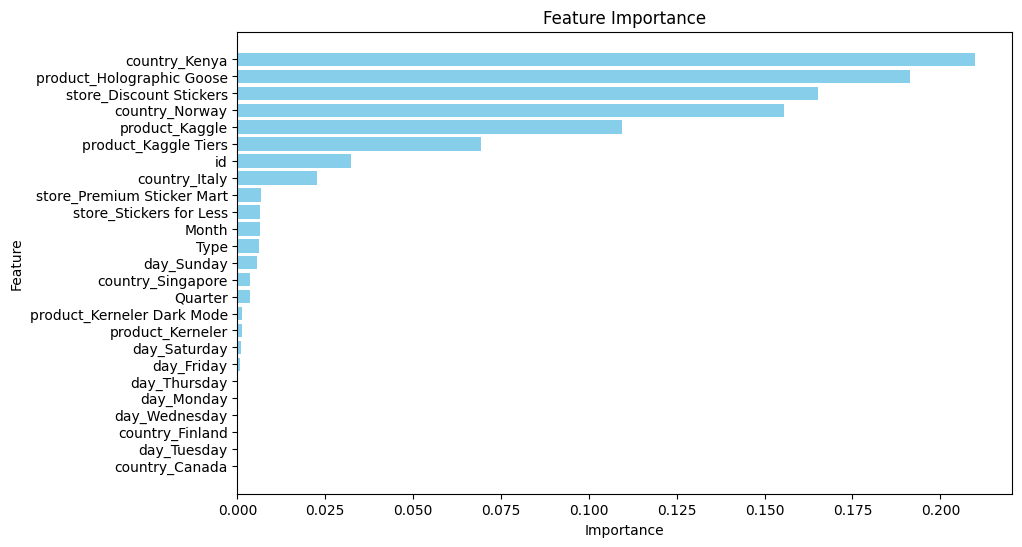

In [57]:
# Extract feature importances
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Print the feature importance table
print(feature_importances)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Highest importance on top
plt.show()

In [58]:
test_data.head()

,id,Type,Month,Quarter,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,country_Canada,country_Finland,country_Italy,country_Kenya,country_Norway,country_Singapore,product_Holographic Goose,product_Kaggle,product_Kaggle Tiers,product_Kerneler,product_Kerneler Dark Mode,store_Discount Stickers,store_Premium Sticker Mart,store_Stickers for Less
date,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01,230130,0,1,1,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False
2017-01-01,230131,0,1,1,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False
2017-01-01,230132,0,1,1,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False
2017-01-01,230133,0,1,1,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False
2017-01-01,230134,0,1,1,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,True,False,False


In [59]:
# Predict on test data

test_predictions = rf_model.predict(test_data)

# Assuming test_data contains an 'id' column for submission
submission = pd.DataFrame({
    'id': test_data['id'],  # Ensure this matches the column name expected in the submission format
    'num_sold': test_predictions  # Predicted values
})

# Save to CSV
submission.to_csv("submission.csv", index=False)
print("Submission file created: submission.csv")

Submission file created: submission.csv
